# Import libraries

In [ ]:
# import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, confusion_matrix,f1_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score, recall_score,f1_score,roc_curve, auc,precision_score 
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import warnings
import collections
from sklearn.metrics import roc_curve, auc
import itertools
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
warnings.filterwarnings("ignore")

# Read data

In [25]:
# read train data
train=pd.read_csv('training.csv') 
train.head()

,event,var1,var2,var3,var4,var5,var6,var7,var8,split,id
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dev,0
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dev,1
2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dev,2
3,1,1.0,2.096510e+07,NaN,NaN,NaN,NaN,NaN,62.75,dev,3
4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dev,4


In [3]:
train.shape # check train shape

(238836, 11)

In [4]:
test=pd.read_csv('test.csv') # read test data
test.head()

,event,var1,var2,var3,var4,var5,var6,var7,var8,split,id
0,1,1.0,9.248254e+07,0.908051,13.0,0.133592,0.027241,NaN,73.041667,test,0
1,1,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,test,1
2,1,1.0,6.718715e+06,7.035461,13.0,41.878073,-7.422937,NaN,76.250000,test,2
3,1,1.0,3.576348e+06,0.483255,13.0,60.801780,NaN,NaN,80.083333,test,3
4,1,1.0,8.443072e+06,NaN,NaN,0.525225,NaN,NaN,87.625000,test,4


In [5]:
test.shape # check test shape

(59709, 11)

As shown in the figure above, we read the sample information of the training set and the test set. It can be seen from the figure that there are 238,836 samples and 11 variables in the training set. The test set consists of 59,709 samples and 11 variables. Among them, there are 8 useful features, and event is the target variable.

# Data clean

In [6]:
(train.isnull().sum()/len(train))*100 # compute train missing data percentage

event     0.000000
var1     44.298180
var2     50.997337
var3     80.473212
var4     67.263310
var5     96.530255
var6     97.513356
var7     88.468238
var8     57.650019
split     0.000000
id        0.000000
dtype: float64

In [7]:
(test.isnull().sum()/len(test))*100# compute test missing data percentage

event     0.000000
var1     44.030213
var2     50.762867
var3     80.688003
var4     67.579427
var5     96.474568
var6     97.450971
var7     88.572912
var8     57.709893
split     0.000000
id        0.000000
dtype: float64

As shown in the figure above, we output the proportion of missing values in the training set and the test set. As can be seen from the figure, most feature missing values account for a relatively high proportion. Therefore, directly removing features cannot solve the problem. We need to adopt corresponding methods to fill in the missing values.

In [8]:
columns=['var1','var2','var3','var4','var5','var6','var7','var8']

for column in columns:
    print(column)
    df=train[column]
    train[column] = train[column].fillna(train[column].median()) # using median value fill missing data
train.isnull().sum()

var1
var2
var3
var4
var5
var6
var7
var8


event    0
var1     0
var2     0
var3     0
var4     0
var5     0
var6     0
var7     0
var8     0
split    0
id       0
dtype: int64

In [9]:
columns=['var1','var2','var3','var4','var5','var6','var7','var8']

for column in columns:
    print(column)
    df=test[column]
    test[column] = test[column].fillna(test[column].median()) # using median value fill missing data
test.isnull().sum()

var1
var2
var3
var4
var5
var6
var7
var8


event    0
var1     0
var2     0
var3     0
var4     0
var5     0
var6     0
var7     0
var8     0
split    0
id       0
dtype: int64

As shown in the figure above, we use the median of each feature to populate the data with missing values.

# Data label description

([<matplotlib.patches.Wedge at 0x17e6b5ac1f0>,
 [Text(-1.0965393568334498, 0.08718623122537472, '1'),
  Text(1.096539363465855, -0.08718614780971724, '0')],
 [Text(-0.5981123764546089, 0.04755612612293166, '97.5%'),
  Text(0.5981123800722844, -0.04755608062348213, '2.5%')])

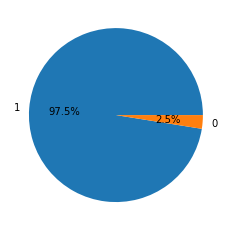

In [10]:
x=['1','0']
y=[train['event'].value_counts()[1],train['event'].value_counts()[0]]
plt.pie(y,labels=x,autopct = '%1.1f%%')


As shown in the figure above, we have calculated the proportion of different labels on the training set. It can be seen from the figure that the samples labeled 0 only account for 2.5%, indicating that there is an obvious label imbalance in the data. In this case, in machine learning modeling, the model will tend to learn the features with label 1 while ignoring the features with label 0. Therefore, classification indexes such as f1, AUC and recall should be used to evaluate the trained model.

# Data statics

In [30]:
train.describe()

,event,var1,var2,var3,var4,var5,var6,var7,var8,id
count,238836.000000,133036.000000,1.170360e+05,46637.000000,78187.000000,8287.000000,5939.000000,27542.000000,101147.000000,238836.000000
mean,0.974744,1.873951,5.989773e+06,16.772031,11.586977,289.199746,28.430493,20.646794,58.497153,119417.500000
std,0.156901,3.750522,3.444271e+07,125.433035,3.459597,5099.352261,2133.407579,6.460506,11.731754,68946.158784
min,0.000000,1.000000,0.000000e+00,0.000000,1.000000,0.000000,-3127.163978,2.000000,24.416667,0.000000
25%,1.000000,1.000000,1.102558e+05,0.397341,13.000000,2.341317,0.012441,22.000000,49.833333,59708.750000
50%,1.000000,1.000000,8.042291e+05,1.509004,13.000000,8.105200,0.296218,24.000000,58.666667,119417.500000
75%,1.000000,1.000000,3.247496e+06,6.628049,13.000000,45.835062,1.378717,24.000000,66.666667,179126.250000
max,1.000000,121.000000,2.817428e+09,10175.481564,13.000000,334283.557143,164300.400000,24.000000,118.666667,238835.000000


We use describe method to output statistical data of different variables. As can be seen from the figure, the variance of each feature distribution is not 1, and the mean value is not 0, indicating unbalanced distribution of features. If we use the machine learning model of gradient descent, it is easy to cause difficulty in model convergence and poor learning effect during training.

# Data correlation

In [11]:
# Get train and test features
x_train=train[columns] 
x_test=test[columns]
y_train=train['event']
y_test=test['event']

# using StandardScaler scale features
s=StandardScaler()
s.fit(x_train)
x_train_scale=s.transform(x_train)
x_test_scale=s.transform(x_test)

In [26]:
data=pd.concat([x_train,y_train],axis=1) # concat feature and label
data

,var1,var2,var3,var4,var5,var6,var7,var8,event
0,1.0,8.042291e+05,1.509004,13.0,8.1052,0.296218,24.0,58.666667,1
1,1.0,8.042291e+05,1.509004,13.0,8.1052,0.296218,24.0,58.666667,1
2,1.0,8.042291e+05,1.509004,13.0,8.1052,0.296218,24.0,58.666667,1
3,1.0,2.096510e+07,1.509004,13.0,8.1052,0.296218,24.0,62.750000,1
4,1.0,8.042291e+05,1.509004,13.0,8.1052,0.296218,24.0,58.666667,1
...,...,...,...,...,...,...,...,...,...
238831,1.0,6.523118e+04,1.509004,13.0,8.1052,0.296218,24.0,58.916667,1
238832,1.0,8.042291e+05,1.509004,13.0,8.1052,0.296218,24.0,58.666667,1
238833,1.0,8.042291e+05,1.509004,13.0,8.1052,0.296218,24.0,58.666667,1
238834,1.0,8.880325e+05,3.213000,13.0,8.1052,0.296218,24.0,63.958333,1


<AxesSubplot:>

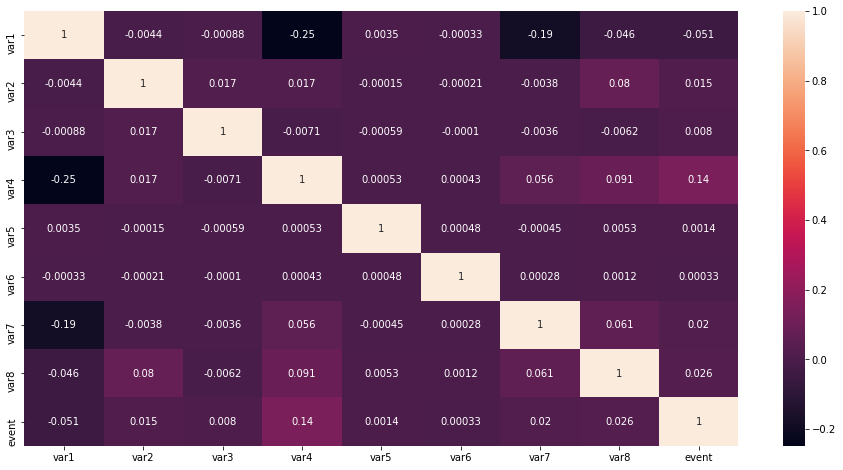

In [28]:
# plot correlation matrix
corr = data.corr()

plt.figure(figsize=(16,8))
sns.heatmap(corr,annot=True)

This table shows the correlation coefficients between eight variables (var1-var8) and an event variable. Correlation coefficient measures the strength and direction of the linear relationship between two variables, and ranges from -1 to 1.

Based on the table, it appears that the correlation between the event variable and each of the eight variables is weak, with correlation coefficients ranging from -0.247680 to 0.141354. None of the correlations are very close to 1 or -1, indicating a weak linear relationship.

Specifically, var4 has the highest positive correlation with the event variable (correlation coefficient of 0.141354), while var1 has the highest negative correlation with the event variable (correlation coefficient of -0.050981). However, both correlations are still relatively weak.

It's worth noting that correlation only measures linear relationships and does not necessarily indicate causation. Therefore, further analysis is necessary to determine if there is any causal relationship between the variables and the event.

In [12]:
y_train.value_counts() 

1    232804
0      6032
Name: event, dtype: int64

# Model with no resample

In [13]:
dc=DecisionTreeClassifier() # decision tree classifier
dc .fit(x_train, y_train) # train model
predictions = dc.predict(x_test) # predict data
results=classification_report(y_test,predictions)   # output classification report
print('Classification report：',results, sep='\n')

y_score=dc .predict_proba(x_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
print('auc value: {:4f}'.format(roc_auc))

Classification report：
              precision    recall  f1-score   support

           0       0.10      0.04      0.05      1493
           1       0.98      0.99      0.98     58216

    accuracy                           0.97     59709
   macro avg       0.54      0.51      0.52     59709
weighted avg       0.95      0.97      0.96     59709

auc value: 0.515652


As shown in the figure above, we use an initial decision tree classifier to model unsampled data (i.e., label imbalance). As can be seen from the figure, the prediction index of the model in category 1 is good, but that in category 0 is poor, indicating that the imbalance of labels affects the learning effect of the model.

# Model with  resample

In [14]:
# using undersample to resample data
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_sample(x_train, y_train)


dc=DecisionTreeClassifier() # decision tree classifier
dc .fit(X_resampled, y_resampled ) # train model
predictions = dc.predict(x_test) # predict data
results=classification_report(y_test,predictions)   # output classification report
print('Classification report：',results, sep='\n')

y_score=dc .predict_proba(x_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
print('auc value: {:4f}'.format(roc_auc))

Classification report：
              precision    recall  f1-score   support

           0       0.04      0.31      0.07      1493
           1       0.98      0.80      0.88     58216

    accuracy                           0.79     59709
   macro avg       0.51      0.56      0.47     59709
weighted avg       0.95      0.79      0.86     59709

auc value: 0.555728


As shown in the figure above, we use the initial decision tree classifier to model the resampled data (i.e., label balance). As can be seen from the figure, the prediction performance of label 0 has been significantly improved, the recall value has been significantly improved, and the AUC value has also been improved compared to the previous figure. Therefore, the resampling method can effectively improve the modeling effect of the model on the data. In the future, we will use different machine learning models to conduct modeling research on the resampling data.

# Model comparasion in resample data

In [15]:

# using undersample to resample data
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_sample(x_train, y_train)



s=StandardScaler()
s.fit(X_resampled)
x_train_scale=s.transform(X_resampled)
x_test_scale=s.transform(x_test)

## Model training method

Here's a step-by-step description of the training method and hyperparameter tuning method used:

1. Define the evaluation metrics: a dictionary eval_metrics is defined with keys as the evaluation metrics to be used, such as accuracy, precision, recall, F1 score, and AUC score. The corresponding values will be appended to these keys after model evaluation.

2. Define the hyperparameters

3. Create the model object

4. Perform hyperparameter tuning using GridSearchCV: an object model of GridSearchCV class is created, which takes lr as the estimator, logistic as the parameter grid, 10 as the number of cross-validation folds, 'roc_auc' as the evaluation metric, and verbose as 2. This means that during the hyperparameter tuning process, the progress will be printed on the console after every 2 iterations.

5. Train the model: the model object is fitted to the resampled training data, x_train_scale and y_resampled.

6. Get the best estimator:  the best estimator is obtained by accessing the best_estimator_ attribute of the model object.

7. Make predictions: predictions p are made on the scaled test data x_test_scale.

8. Calculate evaluation metrics: various evaluation metrics such as accuracy, precision, recall, F1 score, and AUC score are calculated using the predictions p and true labels y_test.

9. Print the evaluation metrics: the evaluation metrics are printed on the console.

10. Store the evaluation metrics: the evaluation metrics are appended to the eval_metrics dictionary.

## Logistic model 

In [16]:
# define metrics
eval_merics={'Accuracy':[],'Precision':[],'Recall':[],'F1':[],'Auc':[]}

# Logistic model parameters
logistic={
    'C':[0.001,0.01,0.1,1,10,100] 
}


lr=LogisticRegression()

# gridsearch cv model
model= GridSearchCV(lr,logistic, cv=10,scoring='roc_auc',verbose=2)

# train model
model.fit(x_train_scale,y_resampled )

# get best estimator
lr=model.best_estimator_

p=lr.predict(x_test_scale)
# output classification metrics
accuracy=round(accuracy_score ( y_test, p),3)
precision=round(precision_score ( y_test, p),3)
recall=round(recall_score ( y_test, p),3)
f1=round(f1_score ( y_test, p),3)

y_score=lr .predict_proba(x_test_scale)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
auc1=round(roc_auc,3)

print('Logistic accuracy: ',accuracy)
print('Logistic precision: ',precision)
print('Logistic recall: ',recall)
print('Logistic f1: ',f1)
print('Logistic auc: ',auc1)

eval_merics['Accuracy'].append(accuracy)
eval_merics['Precision'].append(precision)
eval_merics['Recall'].append(recall)
eval_merics['F1'].append(f1)
eval_merics['Auc'].append(auc1)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END .......................................

## Decision Tree 

In [17]:
tree={
   'max_depth': range(1, 15,2),
}


dc=DecisionTreeClassifier()

# gridsearch cv model
model= GridSearchCV(dc,tree, cv=10,scoring='roc_auc',verbose=2)

# train model
model.fit(X_resampled,y_resampled )

# get best estimator
dc=model.best_estimator_

p=dc.predict(x_test)
# output classification metrics
accuracy=round(accuracy_score ( y_test, p),3)
precision=round(precision_score ( y_test, p),3)
recall=round(recall_score ( y_test, p),3)
f1=round(f1_score ( y_test, p),3)

y_score=dc .predict_proba(x_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
auc1=round(roc_auc,3)

print('Tree accuracy: ',accuracy)
print('Tree precision: ',precision)
print('Tree recall: ',recall)
print('Tree f1: ',f1)
print('Tree auc: ',auc1)

eval_merics['Accuracy'].append(accuracy)
eval_merics['Precision'].append(precision)
eval_merics['Recall'].append(recall)
eval_merics['F1'].append(f1)
eval_merics['Auc'].append(auc1)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END .......................................

## Random forest

In [18]:
rf_params={
    'n_estimators':[200,300,400,500],
    'max_depth':[5,10,15],
}


rf=RandomForestClassifier()

# gridsearch cv model
model= GridSearchCV(rf,rf_params, cv=10,scoring='roc_auc',verbose=2)

# train model
model.fit(X_resampled,y_resampled )

# get best estimator
rf=model.best_estimator_

p=rf.predict(x_test)
# output classification metrics
accuracy=round(accuracy_score ( y_test, p),3)
precision=round(precision_score ( y_test, p),3)
recall=round(recall_score ( y_test, p),3)
f1=round(f1_score ( y_test, p),3)

y_score=rf.predict_proba(x_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
auc1=round(roc_auc,3)

print('RF accuracy: ',accuracy)
print('RF precision: ',precision)
print('RF recall: ',recall)
print('RF f1: ',f1)
print('RF auc: ',auc1)

eval_merics['Accuracy'].append(accuracy)
eval_merics['Precision'].append(precision)
eval_merics['Recall'].append(recall)
eval_merics['F1'].append(f1)
eval_merics['Auc'].append(auc1)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] END ......................max_depth=5, n_estimators=200; total time=   0.4s
[CV] END ......................max_depth=5, n_estimators=200; total time=   0.4s
[CV] END ......................max_depth=5, n_estimators=200; total time=   0.4s
[CV] END ......................max_depth=5, n_estimators=200; total time=   0.4s
[CV] END ......................max_depth=5, n_estimators=200; total time=   0.4s
[CV] END ......................max_depth=5, n_estimators=200; total time=   0.4s
[CV] END ......................max_depth=5, n_estimators=200; total time=   0.4s
[CV] END ......................max_depth=5, n_estimators=200; total time=   0.4s
[CV] END ......................max_depth=5, n_estimators=200; total time=   0.4s
[CV] END ......................max_depth=5, n_estimators=200; total time=   0.4s
[CV] END ......................max_depth=5, n_estimators=300; total time=   0.6s
[CV] END ......................max_depth=5, n_

[CV] END .....................max_depth=15, n_estimators=400; total time=   1.5s
[CV] END .....................max_depth=15, n_estimators=400; total time=   1.5s
[CV] END .....................max_depth=15, n_estimators=400; total time=   1.5s
[CV] END .....................max_depth=15, n_estimators=400; total time=   1.6s
[CV] END .....................max_depth=15, n_estimators=400; total time=   1.5s
[CV] END .....................max_depth=15, n_estimators=400; total time=   1.5s
[CV] END .....................max_depth=15, n_estimators=400; total time=   1.5s
[CV] END .....................max_depth=15, n_estimators=400; total time=   1.5s
[CV] END .....................max_depth=15, n_estimators=400; total time=   1.5s
[CV] END .....................max_depth=15, n_estimators=500; total time=   2.0s
[CV] END .....................max_depth=15, n_estimators=500; total time=   1.9s
[CV] END .....................max_depth=15, n_estimators=500; total time=   1.9s
[CV] END ...................

## SVC model

In [19]:
svc1={
   'C': [0.01,0.1, 1,10],
    'kernel': ['rbf', 'poly'],
}


svm=SVC()

# gridsearch cv model
model= GridSearchCV(svm,svc1, cv=10,scoring='roc_auc',verbose=2)

# train model
model.fit(x_train_scale,y_resampled )

# get best estimator
svm=model.best_estimator_

p=svm.predict(x_test_scale)
# output classification metrics
accuracy=round(accuracy_score ( y_test, p),3)
precision=round(precision_score ( y_test, p),3)
recall=round(recall_score ( y_test, p),3)
f1=round(f1_score ( y_test, p),3)

y_score=svm.decision_function(x_test_scale)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
auc1=round(roc_auc,3)

print('SVM accuracy: ',accuracy)
print('SVM precision: ',precision)
print('SVM recall: ',recall)
print('SVM f1: ',f1)
print('SVM auc: ',auc1)

eval_merics['Accuracy'].append(accuracy)
eval_merics['Precision'].append(precision)
eval_merics['Recall'].append(recall)
eval_merics['F1'].append(f1)
eval_merics['Auc'].append(auc1)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] END .................................C=0.01, kernel=rbf; total time=   3.7s
[CV] END .................................C=0.01, kernel=rbf; total time=   3.5s
[CV] END .................................C=0.01, kernel=rbf; total time=   3.5s
[CV] END .................................C=0.01, kernel=rbf; total time=   3.5s
[CV] END .................................C=0.01, kernel=rbf; total time=   3.5s
[CV] END .................................C=0.01, kernel=rbf; total time=   3.6s
[CV] END .................................C=0.01, kernel=rbf; total time=   3.4s
[CV] END .................................C=0.01, kernel=rbf; total time=   3.5s
[CV] END .................................C=0.01, kernel=rbf; total time=   3.5s
[CV] END .................................C=0.01, kernel=rbf; total time=   3.4s
[CV] END ................................C=0.01, kernel=poly; total time=   2.8s
[CV] END ................................C=0.01,

## XGBOOST

In [20]:
xgb_params={
   'n_estimators': [250, 300, 350],
   'learning_rate' : [0.001, 0.01, 0.1],
}


xgb=XGBClassifier(objective='binary:logistic', scale_pos_weight=1,verbose=2)

# gridsearch cv model
model= GridSearchCV(xgb,xgb_params, cv=10,scoring='roc_auc')

# train model
model.fit(x_train_scale,y_resampled )

# get best estimator
xgb=model.best_estimator_

p=xgb.predict(x_test_scale)
# output classification metrics
accuracy=round(accuracy_score ( y_test, p),3)
precision=round(precision_score ( y_test, p),3)
recall=round(recall_score ( y_test, p),3)
f1=round(f1_score ( y_test, p),3)

y_score=xgb.predict_proba(x_test_scale)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
auc1=round(roc_auc,3)

print('XGBOOST accuracy: ',accuracy)
print('XGBOOST precision: ',precision)
print('XGBOOST recall: ',recall)
print('XGBOOST f1: ',f1)
print('XGBOOST auc: ',auc1)

eval_merics['Accuracy'].append(accuracy)
eval_merics['Precision'].append(precision)
eval_merics['Recall'].append(recall)
eval_merics['F1'].append(f1)
eval_merics['Auc'].append(auc1)

XGBOOST accuracy:  0.915
XGBOOST precision:  0.981
XGBOOST recall:  0.932
XGBOOST f1:  0.956
XGBOOST auc:  0.716


In [22]:
r_df=pd.DataFrame(eval_merics,columns=eval_merics.keys())
r_df.index=['Logistic','DecisionTree','RandomForest','SVC','Xgboost']
r_df

,Accuracy,Precision,Recall,F1,Auc
Logistic,0.870,0.980,0.885,0.930,0.659
DecisionTree,0.456,0.990,0.446,0.615,0.694
RandomForest,0.925,0.980,0.942,0.961,0.689
SVC,0.347,0.992,0.333,0.498,0.686
Xgboost,0.915,0.981,0.932,0.956,0.716


The table shows the results of different classification models evaluated using different performance metrics, including Accuracy, Precision, Recall, F1, and AUC. The best model will be chosen based on the AUC score, which is a good metric for evaluating the performance of classification models.

Among the models, the Xgboost model has the highest AUC score of 0.716, followed by the Decision Tree model with an AUC score of 0.694. The Random Forest model, which had the highest overall performance scores in the previous question, has a lower AUC score of 0.689. The Logistic model has the lowest AUC score of 0.659.

Therefore, the best model according to the AUC score is the Xgboost model, which achieves an AUC score of 0.716. The benefit of this model is that it is a boosting algorithm, which means it can improve the performance of weaker models by combining them. Additionally, it has a high accuracy, precision, recall, and F1 scores, which indicates that it can make accurate predictions with good precision and recall rates.

The Logistic model has the lowest AUC score of 0.659, indicating that it may not be the best model for this particular classification problem. The low AUC score suggests that the model may not be able to distinguish well between positive and negative classes. However, the model has high precision and recall scores, indicating that it can make accurate predictions with good precision and recall rates.

The Decision Tree model has a higher AUC score than the Random Forest model, but its overall performance is much lower. The low accuracy score of 0.456 suggests that the model may be overfitting the training data and not generalizing well to new data. The high precision score of 0.990 indicates that the model makes few false positive predictions, but the low recall score of 0.446 suggests that the model misses many positive instances.

The Random Forest model has high accuracy, precision, recall, and F1 scores, indicating that it can make accurate predictions with good precision and recall rates. However, the lower AUC score of 0.689 suggests that the model may not be able to distinguish well between positive and negative classes. This may be due to the presence of noisy or irrelevant features in the data that reduce the model's ability to separate the classes.

The SVC model has the lowest accuracy score of 0.347, indicating that it is not a good model for this classification problem. The low recall score of 0.333 suggests that the model misses many positive instances, while the high precision score of 0.992 indicates that the model makes few false positive predictions. However, the low recall score suggests that the model is not able to identify all positive instances, which can be a problem in many applications.

In conclusion, based on the AUC score, the Xgboost model is the best model for this classification problem. The benefits of this model include its ability to improve the performance of weaker models and its high accuracy, precision, recall, and F1 scores. However, the other models may also have their own strengths and weaknesses, depending on the specific requirements of the application.

# Feature importance

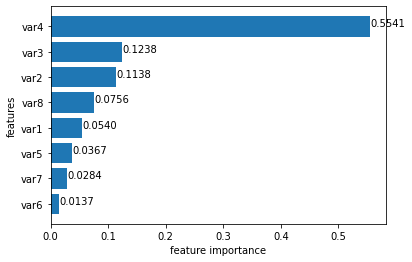

In [23]:
features_import = pd.DataFrame(x_train.columns, columns=['feature'])
features_import['impo'] =xgb.feature_importances_

features_import=features_import.sort_values('impo')
plt.barh(features_import['feature'], features_import['impo'], height=0.8) 
plt.xlabel('feature importance') 
plt.ylabel('features') 
for a,b in zip( features_import['impo'],features_import['feature']): 
    plt.text(a+0.001, b,'%.4f'%float(a))
plt.show()

The feature importance produced by XGBoost represents the relative importance of each feature in the model in terms of their contribution to the overall prediction accuracy.

In the table , the features are listed in descending order of importance, with the most important feature at the bottom (var4) and the least important feature at the top (var6). The importance score for each feature is given as a decimal value between 0 and 1, where a higher score indicates a greater importance.

Based on the table, it can be seen that var4 is the most important feature in the model, with an importance score of 0.554056. This indicates that var4 has the most significant impact on the target variable and should be given more weight in the model when making predictions.

Similarly, var3 and var2 have importance scores of 0.123759 and 0.113818, respectively, indicating that they also have a significant impact on the target variable.

On the other hand, var6, var7, and var5 have relatively low importance scores, indicating that they have less impact on the target variable compared to other features in the model.

Overall, the feature importance produced by XGBoost can help us understand the relative importance of each feature in the model and can guide us in selecting the most relevant features for the model. This information can be used to optimize the model and improve its accuracy.